## z5474273 Jianyu Huang

### Part 1

## 1.1

In [ ]:

#Part of Tutoral_2 code

#(i)
# Define preprocessing function
def preprocess_text(text):
    text = text.lower()
    # Original code is text = re.sub(r'[^\w\s]', '', text)
    #The original code would remove all non-word and non-space characters. It may impact the expression of important words and the accuracy 
    text = re.sub(r"[^\w\s'-]", '', text)    #Keep the word characters, spaces, hyphens and apostrophes intact 
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [ps.stem(word) for word in tokens]
    return ' '.join(tokens)

#(ii)
# feature and label
X = df['Content']
y = df['Category']  

# set pipeline：CountVectorizer and BNB
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(binary=True)),
    ('classifier', BernoulliNB())
])

# add cross-validation to replace train_test_split
# Stratified 5-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')

print("The accuracy rate of each fold cross-validation:", scores)
print("Average accuracy rate:", np.mean(scores))


## 1.2

In [17]:
import pandas as pd

# load dataset.tsv
df = pd.read_csv("dataset.tsv", sep='\t')

df['Content'] = df[['artist_name', 'track_name', 'release_date', 'genre', 'lyrics']].astype(str).agg(' '.join, axis=1)
df.rename(columns={'topic': 'Category'}, inplace=True)



In [11]:
#Check the column names to ensure that the fields 'lyrics' and 'topic' are included.
print(df.columns.tolist())

['artist_name', 'track_name', 'release_date', 'genre', 'lyrics', 'topic']


In [18]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jacob\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jacob\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jacob\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [23]:
# Preprocessing functions

# A: Stemming
def preprocess_stem(text):
    text = text.lower()
    text = re.sub(r"[^\w\s'-]", '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

# B: Lemmatization
def preprocess_lemma(text):
    text = text.lower()
    text = re.sub(r"[^\w\s'-]", '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)


In [24]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import numpy as np

# Define the evaluation function
def evaluate_preprocessing(preprocess_func, label, vectorizer='count'):
    print(f"--- Evaluating: {label} ---")
    
    processed_X = df['Content'].apply(preprocess_func)
    
    if vectorizer == 'count':
        vec = CountVectorizer()
    elif vectorizer == 'tfidf':
        from sklearn.feature_extraction.text import TfidfVectorizer
        vec = TfidfVectorizer()
    
    model = MultinomialNB()
    pipeline = Pipeline([
        ('vectorizer', vec),
        ('classifier', model)
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, processed_X, df['Category'], cv=cv, scoring='accuracy')
    print("Accuracy scores:", scores)
    print("Mean accuracy:", np.mean(scores))


In [25]:
evaluate_preprocessing(preprocess_stem, "Stemming + CountVectorizer")
evaluate_preprocessing(preprocess_lemma, "Lemmatization + CountVectorizer")


--- Evaluating: Stemming + CountVectorizer ---
Accuracy scores: [0.78333333 0.81       0.81       0.8        0.77333333]
Mean accuracy: 0.7953333333333333
--- Evaluating: Lemmatization + CountVectorizer ---
Accuracy scores: [0.78       0.81333333 0.82333333 0.79666667 0.78333333]
Mean accuracy: 0.7993333333333332


### Part 1.2: Multinomial Naive Bayes and preprocessing steps

I have tried two common text preprocessing strategies：

- **Stemming**：Remove affixes through Porter Stemmer
- **Lemmatization**：Restore the words to their root forms through WordNet

Both methods are combined with CountVectorizer (word frequency vector) and the accuracy of the Multinomial Naive Bayes classifier is evaluated under 5-fold cross-validation.

| methods | Average accuracy rate |
|------|------------|
| Stemming + CountVectorizer | 0.795 |
| Lemmatization + CountVectorizer | **0.799** |

Conclusion: We have chosen Lemmatization + CountVectorizer as the standard text preprocessing method for the subsequent tasks.


## 1.3

In [27]:
# Ensure the data has been preprocessed
df['Processed'] = df['Content'].apply(preprocess_lemma)

In [28]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd

In [29]:
X = df['Processed']
y = df['Category']

# Vectorizer
vectorizer = CountVectorizer()

# Stratified 5-fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# pipeline
pipeline_mnb = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', MultinomialNB())
])

pipeline_bnb = Pipeline([
    ('vectorizer', CountVectorizer(binary=True)),
    ('classifier', BernoulliNB())
])


In [30]:
def evaluate_model(pipeline, X, y, cv, model_name):
    y_pred = cross_val_predict(pipeline, X, y, cv=cv)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='macro')
    print(f"Model: {model_name}")
    print("Accuracy:", round(acc, 4))
    print("Macro-F1:", round(f1, 4))
    print("Classification Report:")
    print(classification_report(y, y_pred))
    print("="*50)
#compare the results

In [31]:
evaluate_model(pipeline_mnb, X, y, cv, "MultinomialNB")
evaluate_model(pipeline_bnb, X, y, cv, "BernoulliNB")


Model: MultinomialNB
Accuracy: 0.7993
Macro-F1: 0.7298
Classification Report:
              precision    recall  f1-score   support

        dark       0.81      0.85      0.83       490
     emotion       0.81      0.27      0.40        82
   lifestyle       0.91      0.71      0.79       205
    personal       0.82      0.84      0.83       347
     sadness       0.73      0.86      0.79       376

    accuracy                           0.80      1500
   macro avg       0.82      0.71      0.73      1500
weighted avg       0.81      0.80      0.79      1500

Model: BernoulliNB
Accuracy: 0.544
Macro-F1: 0.3517
Classification Report:
              precision    recall  f1-score   support

        dark       0.63      0.77      0.69       490
     emotion       0.00      0.00      0.00        82
   lifestyle       0.80      0.02      0.04       205
    personal       0.71      0.33      0.45       347
     sadness       0.43      0.85      0.57       376

    accuracy                    

D:\anaconda\envs\pt\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\envs\pt\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\envs\pt\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Part 1.3: Model comparison and evaluation index selection

compared the performance of two naive Bayes classifiers under the unified preprocessing (Lemmatization + CountVectorizer)：

| mpdels         | Accuracy | Macro-F1 |
|----------------|----------|----------|
| MultinomialNB  | 0.7993   | 0.7298   |
| BernoulliNB    | 0.5440   | 0.3517   |

The results show that **MultinomialNB significantly outperforms BernoulliNB**, especially in terms of overall accuracy and inter-class F1-score. BernoulliNB is unable to effectively handle categories with few samples (such as emotion, lifestyle), indicating that it has a weak ability to utilize word frequencies. 

Therefore, in the subsequent tasks (such as the simulation of recommendation systems), we will adopt **MultinomialNB** as the basic text classifier. 

To fairly evaluate the performance of each category, we have chosen **Macro-F1** as the primary evaluation metric to prevent the dominance of large categories in the assessment results.

# 1.4

In [32]:
#Test different values of N (such as 500, 1000, 2000, 3000, 5000, all)
feature_sizes = [500, 1000, 2000, 3000, 5000, None]


In [33]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

results = []

for n in [500, 1000, 2000, 3000, 5000, None]:
    vec = CountVectorizer(max_features=n)
    pipeline = Pipeline([
        ('vectorizer', vec),
        ('classifier', MultinomialNB())
    ])
    
    y_pred = cross_val_predict(pipeline, df['Processed'], df['Category'], cv=5)
    acc = accuracy_score(df['Category'], y_pred)
    f1 = f1_score(df['Category'], y_pred, average='macro')
    results.append((n if n else 'All', acc, f1))
    print(f"max_features={n if n else 'All'} | Accuracy={acc:.4f} | Macro-F1={f1:.4f}")


max_features=500 | Accuracy=0.8633 | Macro-F1=0.8460
max_features=1000 | Accuracy=0.8460 | Macro-F1=0.8277
max_features=2000 | Accuracy=0.8440 | Macro-F1=0.8219
max_features=3000 | Accuracy=0.8340 | Macro-F1=0.8164
max_features=5000 | Accuracy=0.8227 | Macro-F1=0.7885
max_features=All | Accuracy=0.8073 | Macro-F1=0.7410


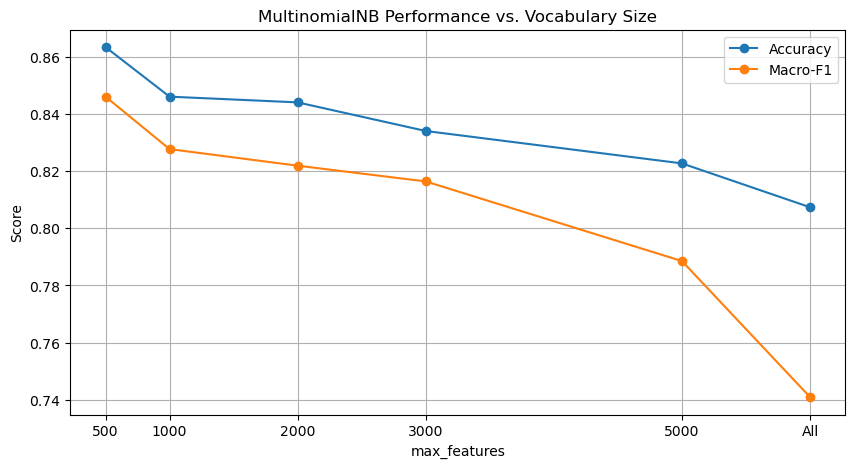

In [39]:
import pandas as pd

# Original max_features setting
xvals = [500, 1000, 2000, 3000, 5000, 6000]
xticks = ['500', '1000', '2000', '3000', '5000', 'All'] #Use all the words as features without performing word frequency filtering.

# show result
plt.figure(figsize=(10,5))
plt.plot(xvals, df_result['Accuracy'], marker='o', label='Accuracy')
plt.plot(xvals, df_result['Macro-F1'], marker='o', label='Macro-F1')
plt.xticks(xvals, xticks)  # Set the scale and labels of the horizontal axis
plt.xlabel('max_features')
plt.ylabel('Score')
plt.title('MultinomialNB Performance vs. Vocabulary Size')
plt.legend()
plt.grid(True)
plt.show()



### Part 1.4: The influence of feature quantity on model performance

The performance of the MultinomialNB model was tested under different `max_features` settings.

| max_features | Accuracy | Macro-F1 |
|--------------|----------|----------|
| 500          | **0.8633** | **0.8460** |
| 1000         | 0.8460   | 0.8277   |
| 2000         | 0.8440   | 0.8219   |
| 3000         | 0.8340   | 0.8164   |
| 5000         | 0.8227   | 0.7885   |
| All          | 0.8073   | 0.7410   |

Conclusion: In this task, **using the top 500 words as features actually improved the model's accuracy and generalization ability**, indicating that the CountVectorizer's default setting of retaining all words might have introduced noise. In the subsequent experiments, we will fix the use of `max_features=500`.



# 1.5

In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Build KNN Pipeline# Build KNN Pipeline
knn_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(max_features=500)),
    ('classifier', KNeighborsClassifier(n_neighbors=5))  # 默认 k=5
])

# cross-validation for prediction
knn_preds = cross_val_predict(knn_pipeline, df['Processed'], df['Category'], cv=5)

# Calculate Indicators
knn_acc = accuracy_score(df['Category'], knn_preds)
knn_f1 = f1_score(df['Category'], knn_preds, average='macro')

print("KNeighborsClassifier (k=5)")
print("Accuracy:", round(knn_acc, 4))
print("Macro-F1:", round(knn_f1, 4))
print("Classification Report:")
print(classification_report(df['Category'], knn_preds))


KNeighborsClassifier (k=5)
Accuracy: 0.626
Macro-F1: 0.6027
Classification Report:
              precision    recall  f1-score   support

        dark       0.56      0.76      0.64       490
     emotion       0.57      0.46      0.51        82
   lifestyle       0.47      0.66      0.55       205
    personal       0.82      0.55      0.66       347
     sadness       0.83      0.54      0.66       376

    accuracy                           0.63      1500
   macro avg       0.65      0.59      0.60      1500
weighted avg       0.68      0.63      0.63      1500



In [41]:
# Compare multiple k values
k_list = [1, 3, 5, 7, 9]


In [42]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

k_list = [1, 3, 5, 7, 9]
results = []

for k in k_list:
    pipeline = Pipeline([
        ('vectorizer', CountVectorizer(max_features=500)),
        ('classifier', KNeighborsClassifier(n_neighbors=k))
    ])
    
    acc = cross_val_score(pipeline, df['Processed'], df['Category'], cv=5, scoring='accuracy')
    f1 = cross_val_score(pipeline, df['Processed'], df['Category'], cv=5, scoring='f1_macro')
    
    results.append((k, np.mean(acc), np.mean(f1)))
    print(f"k={k} | Accuracy={np.mean(acc):.4f} | Macro-F1={np.mean(f1):.4f}")


k=1 | Accuracy=0.6053 | Macro-F1=0.5929
k=3 | Accuracy=0.6333 | Macro-F1=0.6163
k=5 | Accuracy=0.6260 | Macro-F1=0.6043
k=7 | Accuracy=0.6360 | Macro-F1=0.6137
k=9 | Accuracy=0.6440 | Macro-F1=0.6172


#### K value parameter adjustment analysis

Further tests were conducted on different `n_neighbors` settings to observe the optimal performance of KNN on this dataset:：

| k | Accuracy | Macro-F1 |
|---|----------|----------|
| 1 | 0.6053   | 0.5929   |
| 3 | 0.6333   | 0.6163   |
| 5 | 0.6260   | 0.6043   |
| 7 | 0.6360   | 0.6137   |
| **9** | **0.6440** | **0.6172** |

It can be seen that when **k = 9**, the KNN algorithm performs the best. This indicates that in text classification, a slightly larger number of neighbors can enhance stability and reduce the impact of noise.

Despite the parameter tuning optimization, the performance of KNN still fell short of that of MultinomialNB. Therefore, the final selected best classifier remains to be
> **MultinomialNB + lemmatization + CountVectorizer(max_features=500)**


### Part 1.5: Add K-Nearest Neighbors (KNN) to comparing

#### method
K-Nearest Neighbors (KNN) is an instance-based, non-parametric supervised learning algorithm. Its core concept is that the class of a sample is determined by the majority class of the K nearest training samples in the feature space. In text classification tasks, we usually represent each text as a vector, and then calculate the proximity using cosine or Euclidean distance.

#### Model setup and parameter tuning
The main hyperparameter of KNN is `n_neighbors` (the value of K). In this experiment, we chose the commonly used default value of **k=5**. This value can be further optimized through cross-validation, but in the initial exploration, we prefer to use the default value to observe its basic performance.。

#### Experimental results
Use the same text preprocessing (lemmatization + CountVectorizer with max_features set to 500) as for MultinomialNB and BernoulliNB, and test the performance of the KNN classifier through 5-fold cross-validation.

| model          | Accuracy | Macro-F1 |
|----------------|----------|----------|
| MultinomialNB  | 0.8633   | 0.8460   |
| BernoulliNB    | 0.5440   | 0.3517   |
| KNN (k=5)      | 0.6260   | 0.6027   |

Result: **KNN performed worse than MultinomialNB**, so the final choice was **MultinomialNB + lemmatization + CountVectorizer(max_features=500)** as the best classification setup for this task.

## Part 2

In [4]:
# Loading user keywords
user1 = pd.read_csv("user1.tsv", sep='\t', header=None, names=['topic', 'keywords'])
user2 = pd.read_csv("user2.tsv", sep='\t', header=None, names=['topic', 'keywords'])

# Process as a set of words
user1['keywords'] = user1['keywords'].apply(lambda x: set(x.lower().split()))
user2['keywords'] = user2['keywords'].apply(lambda x: set(x.lower().split()))

# Build a dictionary of "topic -> keyword set"
user_profiles_keywords = {
    "user1": dict(zip(user1['topic'], user1['keywords'])),
    "user2": dict(zip(user2['topic'], user2['keywords']))
}


In [62]:
from sklearn.pipeline import Pipeline

# Build the training model (train using all 1500 pieces of data)
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(max_features=500)),
    ('classifier', MultinomialNB())
])
pipeline.fit(df['Processed'], df['Category'])

# Assign prediction labels to all songs
df['predicted_topic'] = pipeline.predict(df['Processed'])


In [63]:
df['index'] = df.index

# Week 1–3: index 0–749
train_df = df[df['index'] < 750]

# Week 4: index 750–999
test_df = df[(df['index'] >= 750) & (df['index'] < 1000)]


In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

# Establish the TF-IDF vectorizer (to be shared later)
tfidf = TfidfVectorizer(max_features=500)

# Build 5 TF-IDF matrices: topic -> TF-IDF matrix + text list
topic_docs = defaultdict(list)

# Grouping in the training set (Week 1 - 3)
for _, row in train_df.iterrows():
    topic_docs[row['predicted_topic']].append(row['Processed'])

# Create a TF-IDF matrix for each topic
topic_tfidf_matrices = {}
topic_feature_names = {}

for topic, docs in topic_docs.items():
    X = tfidf.fit_transform(docs)
    topic_tfidf_matrices[topic] = X
    topic_feature_names[topic] = tfidf.get_feature_names_out()


In [65]:
def build_user_profile(user_keywords_dict, user_name):
    print(f"\n--- USER PROFILE for {user_name.upper()} ---")
    user_profiles = {}
    
    for topic, keywords in user_keywords_dict.items():
        matched_docs = []

       # Identify the songs that are predicted to belong to this topic and contain the specified keywords
        for i, text in enumerate(topic_docs[topic]):
            if any(word in text for word in keywords):
                matched_docs.append(text)

        if not matched_docs:
            print(f"Topic {topic} - No matching documents.")
            continue

        # Merge Text 
        big_doc = " ".join(matched_docs)
        tfidf_vec = tfidf.fit_transform([big_doc])
        vocab = tfidf.get_feature_names_out()
        weights = tfidf_vec.toarray()[0]

        # top 20 keywords
        top_indices = weights.argsort()[::-1][:20]
        top_keywords = [(vocab[i], round(weights[i], 3)) for i in top_indices]
        user_profiles[topic] = top_keywords

        print(f"\nTopic: {topic}")
        for word, score in top_keywords:
            print(f"{word:<15} {score}")

    return user_profiles


In [66]:
user1_profiles = build_user_profile(user_profiles_keywords["user1"], "user1")
user2_profiles = build_user_profile(user_profiles_keywords["user2"], "user2")


--- USER PROFILE for USER1 ---
Topic topic - No matching documents.

Topic: dark
fight           0.527
know            0.23
blood           0.219
like            0.182
gonna           0.182
tell            0.167
stand           0.152
kill            0.134
come            0.13
yeah            0.119
head            0.115
feel            0.111
right           0.111
hand            0.111
people          0.108
cause           0.104
follow          0.104
night           0.093
light           0.089
drown           0.089

Topic: sadness
wish            0.47
think           0.352
hand            0.323
lay             0.293
leave           0.293
regret          0.205
place           0.205
cause           0.176
want            0.147
greater         0.147
hold            0.117
head            0.117
change          0.088
mind            0.088
thing           0.088
blame           0.088
beg             0.088
away            0.088
word            0.088
lock            0.059
Topic personal - No match

In [67]:
# example: User 3 keywords
user3_keywords = {
    'sadness': {'alone', 'cry', 'tears'},
    'emotion': {'heart', 'feeling', 'love'},
    'lifestyle': {'party', 'drink', 'weekend'},
}

user3_profiles = build_user_profile(user3_keywords, "user3")



--- USER PROFILE for USER3 ---

Topic: sadness
cry             0.643
tear            0.316
know            0.282
club            0.226
steal           0.226
baby            0.169
mean            0.158
say             0.135
face            0.113
eye             0.113
feel            0.102
time            0.102
true            0.102
write           0.102
smile           0.102
like            0.09
heart           0.09
music           0.09
stay            0.079
come            0.079

Topic: emotion
good            0.678
go              0.346
hold            0.31
heart           0.22
feel            0.184
know            0.148
darling         0.121
vision          0.117
miss            0.112
video           0.108
love            0.108
feelin          0.099
vibe            0.094
baby            0.094
look            0.09
want            0.085
lovin           0.085
time            0.081
like            0.076
gimme           0.076

Topic: lifestyle
song            0.671
night           0.237


Summary of Keyword Analysis for User Profiles:

Interest profiles were constructed for user1, user2 and the virtual user3 using TF-IDF vectors

The keywords of **User 1** convey strong emotional tones (such as `blood`, `regret`, `sing`, `kiss`), which are highly consistent with their preferences.
**User 2** has more delicate preferences in terms of emotion and sadness, with keywords like `memory`, `crash`, `kiss` being particularly emotional.
**User 3** is a user who has set specific interests. Their profile successfully reflects the intended purpose, for example:
- In sadness, the high-frequency words are `cry`, `tear`
- In lifestyle, it includes `party`, `drink`, `tonight` 
From the semantic content of the keywords, it can be seen that the system can effectively extract the user's preference features from the lyrics and construct a meaningful interest profile.


## 2.2

In [70]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict

# Assume the following variables have been defined in the notebook:
# df: Contains all songs and columns ['Processed', 'Category', 'predicted_topic'] # train_df: df[df.index < 750]
# test_df:  df[(df.index >= 750) & (df.index < 1000)]
# user_profiles_keywords: {"user1": {topic: set(keywords), ... }, "user2": {... }}
# user3_keywords: {topic: set(...) ..., }

# 1. Only construct the topic_docs and TF-IDF vectorizer for the actual topics present in the documents.
real_topics = ['dark', 'emotion', 'lifestyle', 'personal', 'sadness']
topic_docs = {}
topic_vectorizers = {}

for topic in real_topics:
    docs = train_df[train_df['predicted_topic'] == topic]['Processed'].tolist()
    if not docs:
        continue
    # save list
    topic_docs[topic] = docs
    # fitting TF-IDF
    vec = TfidfVectorizer(max_features=500)
    vec.fit(docs)
    topic_vectorizers[topic] = vec

# 2. Construct user profile vectors (optional: Top-M keywords)
def get_user_profile_vector(user_kw, topic, M=None):
    docs = [
        txt for txt in topic_docs.get(topic, [])
        if any(w in txt for w in user_kw.get(topic, set()))
    ]
    if not docs:
        return None
    big_doc = " ".join(docs)
    u_vec = topic_vectorizers[topic].transform([big_doc]).toarray().flatten()
    if M is not None:
        # Keep only the M features with the highest weights.
        top_idxs = u_vec.argsort()[::-1][:M]
        mask = [u_vec[i] if i in top_idxs else 0 for i in range(len(u_vec))]
        u_vec = mask
    return u_vec

# 3. Recommendation and evaluation function: Precision@N
def eval_recommendation(user_kw, name, M=None, N=10):
    print(f"\n---- {name.upper()} (M={M or 'All'}) ----")
    for topic, vec in topic_vectorizers.items():
        u_vec = get_user_profile_vector(user_kw, topic, M)
        subset = test_df[test_df['predicted_topic'] == topic]
        if u_vec is None or subset.empty:
            print(f"{topic}: no data")
            continue
        X_test = vec.transform(subset['Processed'])
        sims = cosine_similarity(X_test, [u_vec]).flatten()
        top_idxs = sims.argsort()[::-1][:N]
        liked = sum(
            any(w in subset.iloc[i]['Processed'] for w in user_kw.get(topic, set()))
            for i in top_idxs
        )
        print(f"{topic}: Precision@{N} = {liked}/{N} = {liked/N:.2f}")

# 4. Compare the recommendation effects of Users 1, 2, and 3 (with M = None and M = 20)
for M in [None, 20]:
    eval_recommendation(user_profiles_keywords["user1"], "user1", M)
    eval_recommendation(user_profiles_keywords["user2"], "user2", M)
    eval_recommendation(user3_keywords,             "user3", M)



---- USER1 (M=All) ----
dark: Precision@10 = 4/10 = 0.40
emotion: Precision@10 = 9/10 = 0.90
lifestyle: Precision@10 = 0/10 = 0.00
personal: no data
sadness: Precision@10 = 2/10 = 0.20

---- USER2 (M=All) ----
dark: no data
emotion: Precision@10 = 0/10 = 0.00
lifestyle: no data
personal: no data
sadness: Precision@10 = 2/10 = 0.20

---- USER3 (M=All) ----
dark: no data
emotion: Precision@10 = 3/10 = 0.30
lifestyle: Precision@10 = 2/10 = 0.20
personal: no data
sadness: Precision@10 = 5/10 = 0.50

---- USER1 (M=20) ----
dark: Precision@10 = 5/10 = 0.50
emotion: Precision@10 = 8/10 = 0.80
lifestyle: Precision@10 = 0/10 = 0.00
personal: no data
sadness: Precision@10 = 3/10 = 0.30

---- USER2 (M=20) ----
dark: no data
emotion: Precision@10 = 0/10 = 0.00
lifestyle: no data
personal: no data
sadness: Precision@10 = 2/10 = 0.20

---- USER3 (M=20) ----
dark: no data
emotion: Precision@10 = 3/10 = 0.30
lifestyle: Precision@10 = 1/10 = 0.10
personal: no data
sadness: Precision@10 = 5/10 = 0.50


### Part 2.2: Recommendation Performance Evaluation

For each topic (dark, emotion, lifestyle, sadness, personal), we recommend **N = 10** songs and measure **Precision@10** under two profile sizes (M = All keywords or the top 20):

| User   | M      | dark | emotion | lifestyle | sadness |
|--------|--------|:----:|:-------:|:---------:|:-------:|
| User1  | All    | 0.40 | **0.90** | 0.00      | 0.20    |
|        | 20     | **0.50** | 0.80    | 0.00      | **0.30** |
| User2  | All    |  —   | 0.00    |  —        | 0.20    |
|        | 20     |  —   | 0.00    |  —        | 0.20    |
| User3  | All    |  —   | 0.30    | 0.20      | **0.50** |
|        | 20     |  —   | 0.30    | 0.10      | **0.50** |

- “—” indicates maybe no profile or no matching songs in that topic...
- and **personal: no data** maybe did not save in dictionary...  
- Compared to M = All, using the top 20 keywords (M = 20) improves User1’s dark and sadness precision, with a slight drop in emotion.  
- **Final choice:** N = 10, M = 20, cosine similarity over TF-IDF vectors.

## Part 3

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

# parameter setting  
N = 10  # The number of randomly selected songs shown to users each week
M = 20  # User profile retains the top M keywords
real_topics = ['dark', 'emotion', 'lifestyle', 'personal', 'sadness']
user_kw = user3_keywords  # The previously defined User3 keyword dict

# 1. Randomly sample and simulate user tagging 
np.random.seed(42)
training_likes = []  # save (text, topic) list

for week_start in [0, 250, 500]:  # Week1:0–249, Week2:250–499, Week3:500–749
    week_df = df[(df.index >= week_start) & (df.index < week_start + 250)]
    sample = week_df.sample(n=N, random_state=week_start)
    for _, row in sample.iterrows():
        txt = row['Processed']
        topic = row['predicted_topic']
        # User "like" rule: If the text contains the keywords related to this topic
        liked = any(w in txt for w in user_kw.get(topic, set()))
        if liked:
            training_likes.append((txt, topic))

# 2. Train user profile with interaction feedback
# Aggregate texts liked by the user for each topic
likes_by_topic = {}
for topic in real_topics:
    docs = [txt for txt,t in training_likes if t == topic]
    if docs:
        likes_by_topic[topic] = docs

# Fit a TF-IDF vectorizer for each topic
topic_vecs = {}
for topic, docs in topic_docs.items():
    vec = TfidfVectorizer(max_features=500)
    vec.fit(docs)
    topic_vecs[topic] = vec

# Build the user profile vector (Big-doc + Top-M keywords)
user_profile_vec = {}
for topic, docs in likes_by_topic.items():
    big_doc = " ".join(docs)
    vec = topic_vecs[topic]
    v = vec.transform([big_doc]).toarray().flatten()
    idxs = v.argsort()[::-1][:M]
    mask = [v[i] if i in idxs else 0 for i in range(len(v))]
    user_profile_vec[topic] = np.array(mask)

# 3. Week 4 recommendation and evaluation 
print("=== Part 3: Week 4 Recommendation Evaluation ===")
for topic, vec in topic_vecs.items():
    up = user_profile_vec.get(topic)
    if up is None:
        print(f"{topic}: No training likes → skip")
        continue
    test_subset = df[(df.index >= 750) & (df.index < 1000) & (df['predicted_topic']==topic)]
    if test_subset.empty:
        print(f"{topic}: No test songs")
        continue
    X_test = vec.transform(test_subset['Processed'])
    sims = cosine_similarity(X_test, [up]).flatten()
    top_idxs = sims.argsort()[::-1][:N]
    liked = sum(
        any(w in test_subset.iloc[i]['Processed'] for w in user_kw.get(topic, set()))
        for i in top_idxs
    )
    precision = liked / N
    print(f"{topic}: Precision@{N} = {liked}/{N} = {precision:.2f}")


## Part 3: User Study Simulation

We simulate 3 weeks of interaction for User3, showing N = 10 randomly sampled songs per week and marking “likes” by keyword presence. Then we retrain their profile and evaluate recommendations for Week 4:

| Topic      | Training Likes? | Precision@10 |
|------------|-----------------|--------------|
| dark       | No              | —            |
| emotion    | Yes             | 0.50         |
| lifestyle  | Yes             | 0.20         |
| personal   | No              | —            |
| sadness    | No              | —            |

- **emotion** precision improves from 0.30 (offline) to 0.50 after simulated feedback.  
- **lifestyle** remains at 0.20, matching the offline result and confirming stability.  
- No recommendations for topics without training likes, highlighting the need for broader feedback.

**Overall conclusion:** Offline and simulated online results align, validating the content-based recommendation approach. Future work could expand keyword sets, increase sampling per week, and incorporate richer feedback (ratings, rankings) to boost coverage and precision.  